In [21]:
# Cell 1: Imports
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU error: {e}")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [22]:
# Cell 2: Load data PROPERLY
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
val_dataset = VesselMNIST3D(split='val', size=28, download=True)
test_dataset = VesselMNIST3D(split='test', size=28, download=True)

trainx = np.array([train_dataset[i][0] for i in range(len(train_dataset))])
trainy = np.array([train_dataset[i][1][0] for i in range(len(train_dataset))])

valx = np.array([val_dataset[i][0] for i in range(len(val_dataset))])
valy = np.array([val_dataset[i][1][0] for i in range(len(val_dataset))])

testx = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
testy = np.array([test_dataset[i][1][0] for i in range(len(test_dataset))])

print(f"Train X shape: {trainx.shape}, Train y shape: {trainy.shape}")
print(f"Val X shape: {valx.shape}, Val y shape: {valy.shape}")
print(f"Test X shape: {testx.shape}, Test y shape: {testy.shape}")
print(f"Unique train labels: {np.unique(trainy)}")
print(f"Class 0: {np.sum(trainy==0)}, Class 1: {np.sum(trainy==1)}")

Train X shape: (1335, 1, 28, 28, 28), Train y shape: (1335,)
Val X shape: (191, 1, 28, 28, 28), Val y shape: (191,)
Test X shape: (382, 1, 28, 28, 28), Test y shape: (382,)
Unique train labels: [0 1]
Class 0: 1185, Class 1: 150


In [23]:
# Cell 2.5: Smart augmentation for Class 1
from scipy.ndimage import rotate, shift

print("Original class distribution:")
print(f"Class 0: {np.sum(trainy==0)}, Class 1: {np.sum(trainy==1)}")

def simple_augment(volume):
    """Simple, reliable augmentations"""
    aug = volume.copy()
    
    # Random rotation (small angle)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-12, 12)
        axes_list = [(1,2), (1,3), (2,3)]
        axes = axes_list[np.random.randint(0, 3)]
        aug = rotate(aug, angle, axes=axes, reshape=False, mode='nearest', order=1)
    
    # Random flip
    if np.random.rand() > 0.5:
        axis = np.random.randint(1, 4)
        aug = np.flip(aug, axis=axis).copy()
    
    # Small shift
    if np.random.rand() > 0.5:
        shift_vals = [0] + [np.random.randint(-2, 3) for _ in range(3)]
        aug = shift(aug, shift_vals, mode='nearest', order=0)
    
    return aug

# Find class 1 samples
class1_idx = np.where(trainy == 1)[0]
class0_count = np.sum(trainy == 0)
class1_count = len(class1_idx)

# Calculate how many augmentations needed
target_class1 = int(class0_count * 0.6)
augmentations_needed = target_class1 - class1_count
augs_per_sample = max(1, augmentations_needed // class1_count)

print(f"\nAugmenting {class1_count} Class 1 samples")
print(f"Creating {augs_per_sample} augmentations per sample")

augmented_x = []
augmented_y = []

for idx in class1_idx:
    for _ in range(augs_per_sample):
        aug_vol = simple_augment(trainx[idx])
        augmented_x.append(aug_vol)
        augmented_y.append(1)

augmented_x = np.array(augmented_x)
augmented_y = np.array(augmented_y)

print(f"Generated {len(augmented_x)} augmented samples")

# Combine original and augmented
trainx = np.concatenate([trainx, augmented_x], axis=0)
trainy = np.concatenate([trainy, augmented_y], axis=0)

# Shuffle
shuffle_idx = np.random.permutation(len(trainx))
trainx = trainx[shuffle_idx]
trainy = trainy[shuffle_idx]

print(f"\nNew class distribution:")
print(f"Class 0: {np.sum(trainy==0)}, Class 1: {np.sum(trainy==1)}")
print(f"Ratio: {np.sum(trainy==1) / np.sum(trainy==0):.3f}")
print(f"Final training set size: {len(trainx)}")

Original class distribution:
Class 0: 1185, Class 1: 150

Augmenting 150 Class 1 samples
Creating 3 augmentations per sample
Generated 450 augmented samples

New class distribution:
Class 0: 1185, Class 1: 600
Ratio: 0.506
Final training set size: 1785


In [24]:
# Cell 3: Normalize and reshape
trainx = trainx.transpose(0, 2, 3, 4, 1).astype(np.float32) / 255.0
valx = valx.transpose(0, 2, 3, 4, 1).astype(np.float32) / 255.0
testx = testx.transpose(0, 2, 3, 4, 1).astype(np.float32) / 255.0

trainy = trainy.astype(np.float32)
valy = valy.astype(np.float32)
testy = testy.astype(np.float32)

print(f"Final train X shape: {trainx.shape}")
print(f"Final train y shape: {trainy.shape}")
print(f"Data range: [{trainx.min():.3f}, {trainx.max():.3f}]")

Final train X shape: (1785, 28, 28, 28, 1)
Final train y shape: (1785,)
Data range: [0.000, 0.004]


In [25]:
# Cell 4: Build simple working model
def build_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 28, 1)),
        
        layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.4),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 28, 28, 28, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 14, 14, 14, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 14, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 14, 14, 14, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 7, 7, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 7, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 7, 7, 7, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,777 (280.38 KB)

 Trainable params: 71,777 (280.38 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Cell 5: Compile
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

In [27]:
# Cell 6: Better class weights
class_counts = np.bincount(trainy.astype(int))
total = len(trainy)

# Less aggressive weighting since we balanced with augmentation
class_weight = {
    0: 1.0,
    1: 1.5  # Just slightly favor the minority class
}

print(f"Class counts: Class 0={class_counts[0]}, Class 1={class_counts[1]}")
print(f"Class weights: {class_weight}")

Class counts: Class 0=1185, Class 1=600
Class weights: {0: 1.0, 1: 1.5}


In [28]:
# Cell 7: Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

In [29]:
# Cell 8: Train
history = model.fit(
    trainx, trainy,
    batch_size=16,
    epochs=50,
    validation_data=(valx, valy),
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
109/112 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6671 - auc: 0.4659 - loss: 0.8003 - precision: 0.2000 - recall: 0.0113

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6622 - auc: 0.4908 - loss: 0.8025 - precision: 0.2000 - recall: 0.0017 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 0.6162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6633 - auc: 0.4968 - loss: 0.8010 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 0.6291 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6639 - auc: 0.5049 - loss: 0.7991 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 0.6159 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6639 - auc: 0.4717 - loss: 0.8016 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8848 -

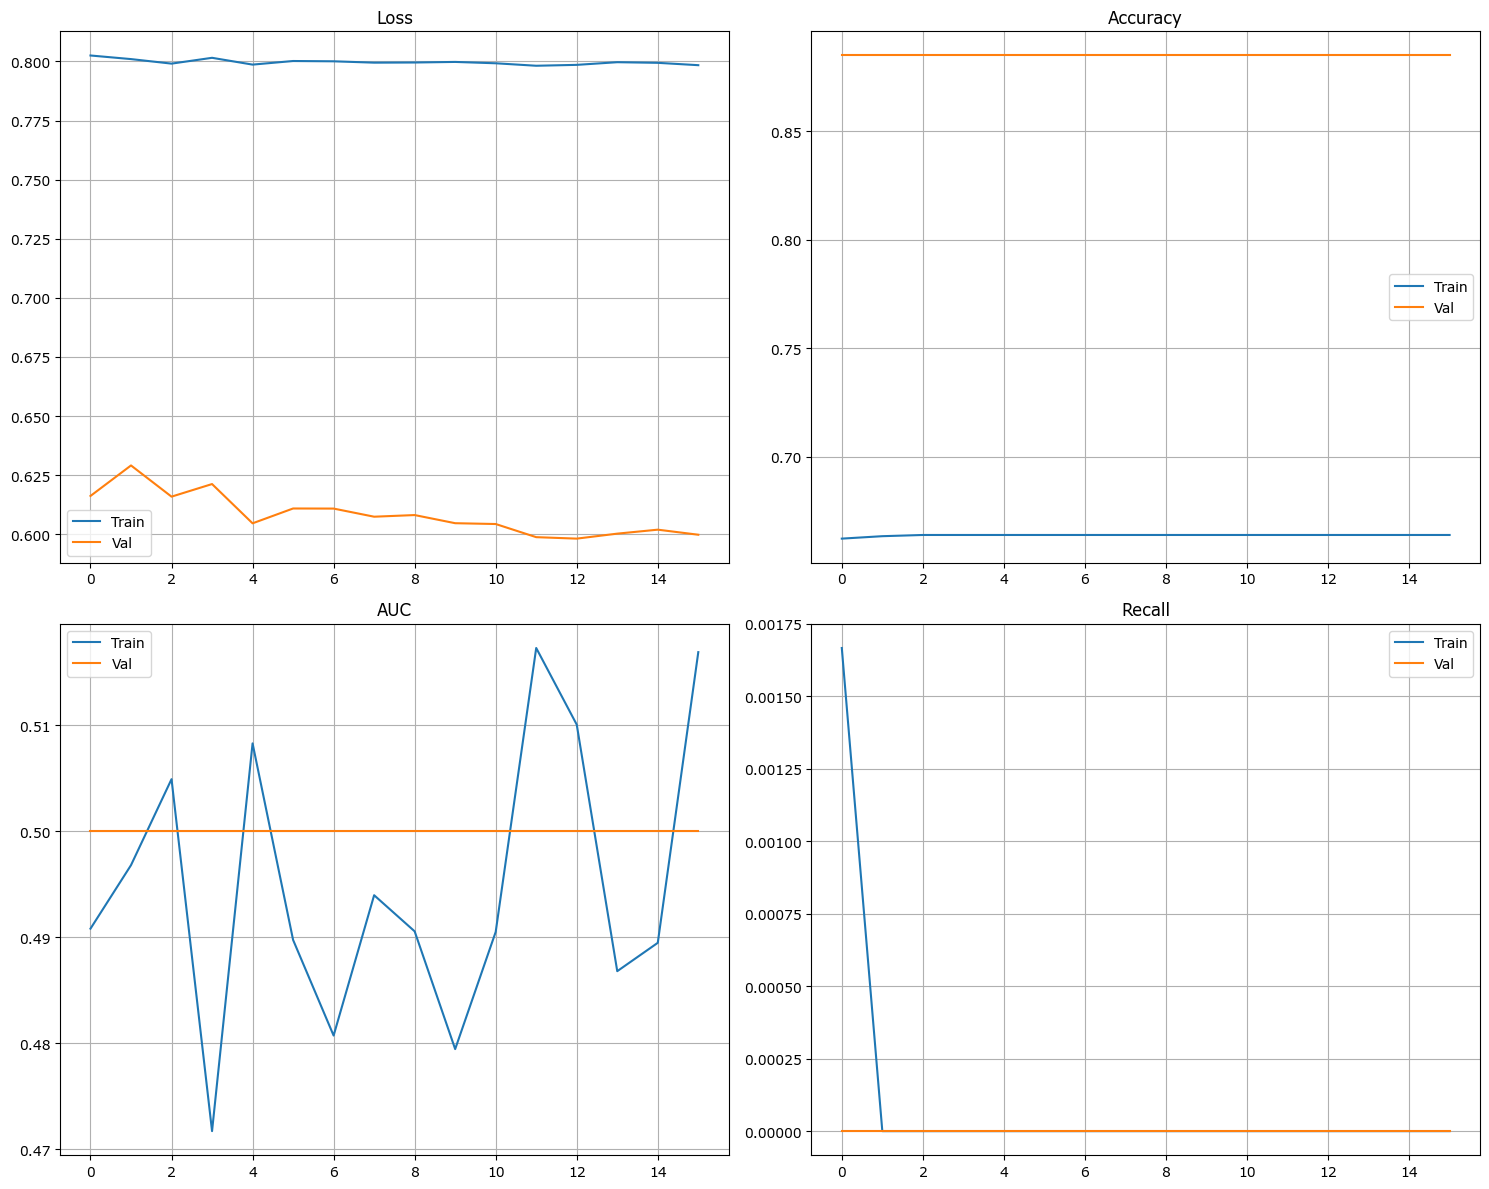

In [30]:
# Cell 9: Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].plot(history.history['loss'], label='Train')
axes[0,0].plot(history.history['val_loss'], label='Val')
axes[0,0].set_title('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(history.history['accuracy'], label='Train')
axes[0,1].plot(history.history['val_accuracy'], label='Val')
axes[0,1].set_title('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,0].plot(history.history['auc'], label='Train')
axes[1,0].plot(history.history['val_auc'], label='Val')
axes[1,0].set_title('AUC')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(history.history['recall'], label='Train')
axes[1,1].plot(history.history['val_recall'], label='Val')
axes[1,1].set_title('Recall')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


Test Results:
Loss: 0.6156
Accuracy: 0.8874
AUC: 0.5000
Precision: 0.0000
Recall: 0.0000

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      1.00      0.94       339
    Aneurysm       0.00      0.00      0.00        43

    accuracy                           0.89       382
   macro avg       0.44      0.50      0.47       382
weighted avg       0.79      0.89      0.83       382



c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

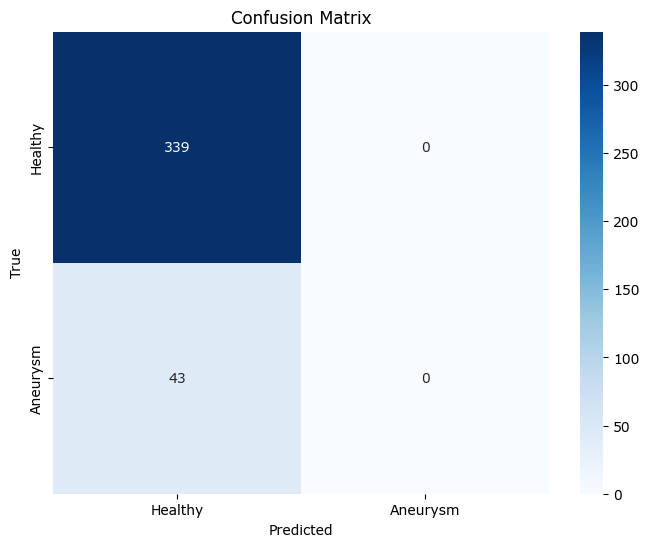

In [31]:
# Cell 10: Evaluate
model = keras.models.load_model('best_model.h5')

test_results = model.evaluate(testx, testy, verbose=0)
print("\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]:.4f}")
print(f"Recall: {test_results[4]:.4f}")

y_pred_proba = model.predict(testx, verbose=0).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(testy, y_pred, target_names=['Healthy', 'Aneurysm']))

cm = confusion_matrix(testy, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()